/var/folders/kv/bh_l9_gs2s16r3y1nq64t49w0000gn/T/ipykernel_1919/1592913715.py:41: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  charge_df["Charge_Capacity(Ah)"] = charge_df.groupby("Cycle_Index", group_keys=False).apply(compute_capacity)
/var/folders/kv/bh_l9_gs2s16r3y1nq64t49w0000gn/T/ipykernel_1919/1592913715.py:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  discharge_df["Discharge_Capacity(Ah)"] = dis

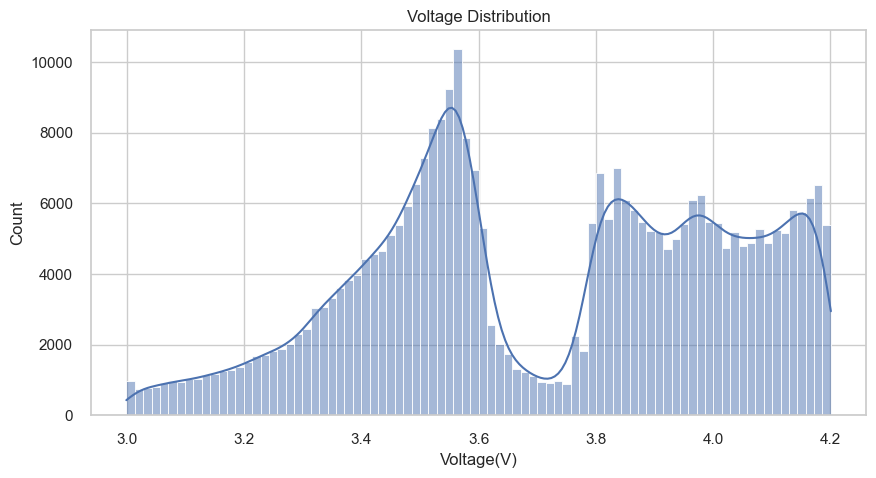

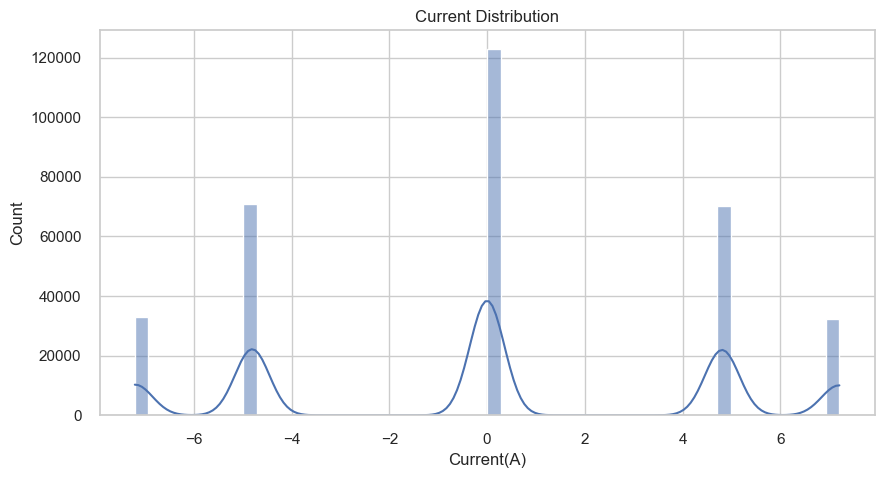

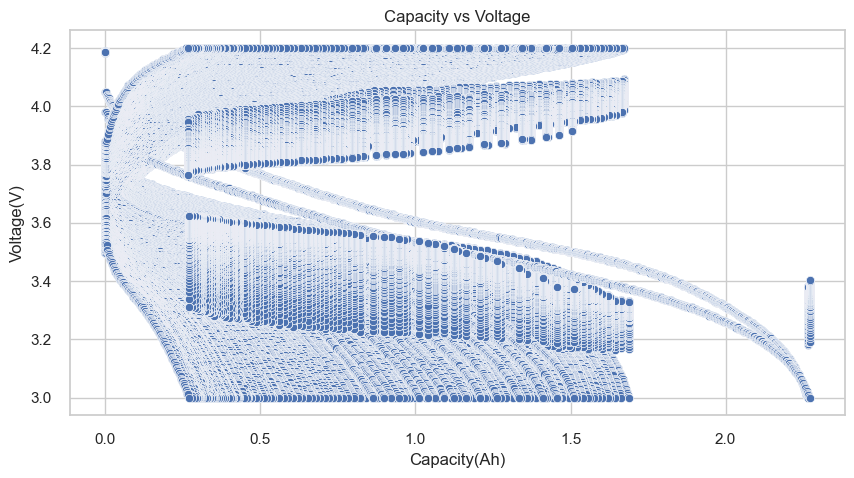

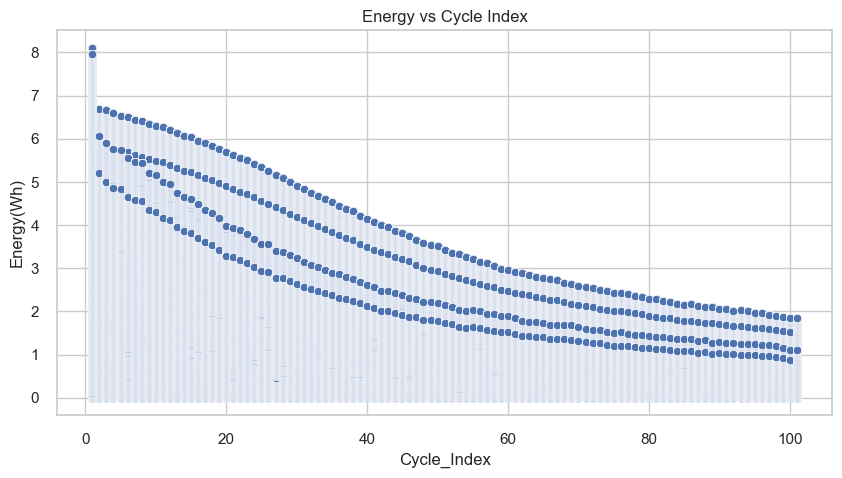

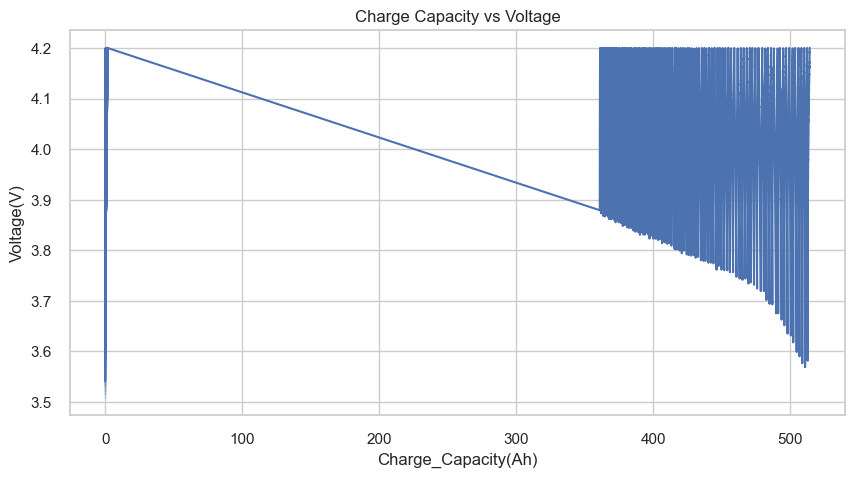

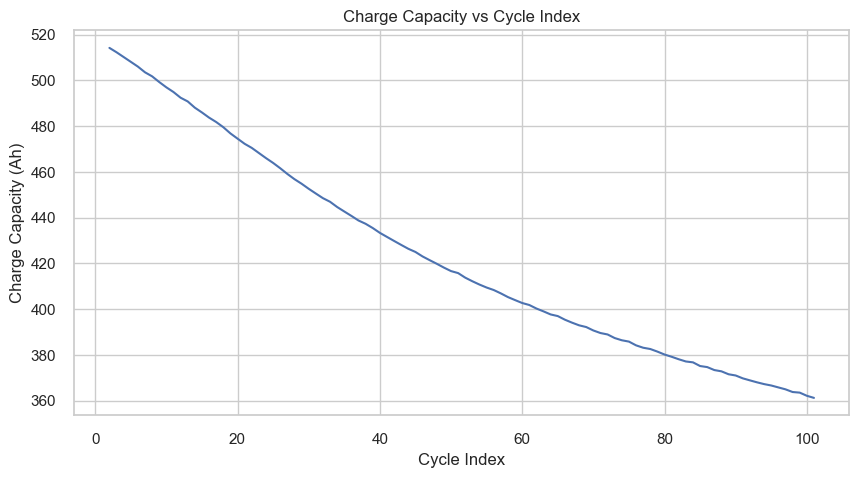

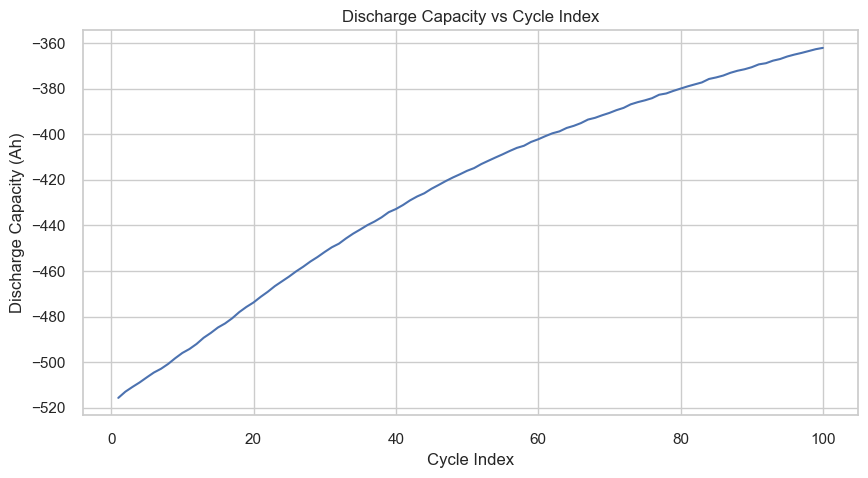

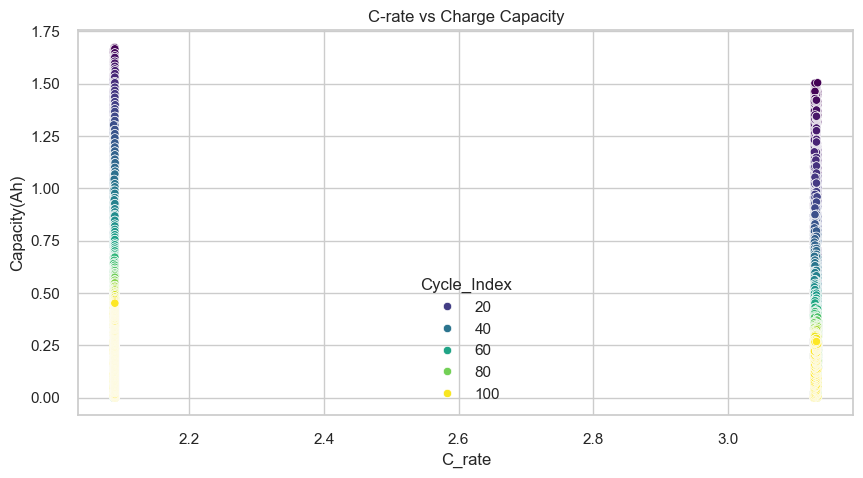

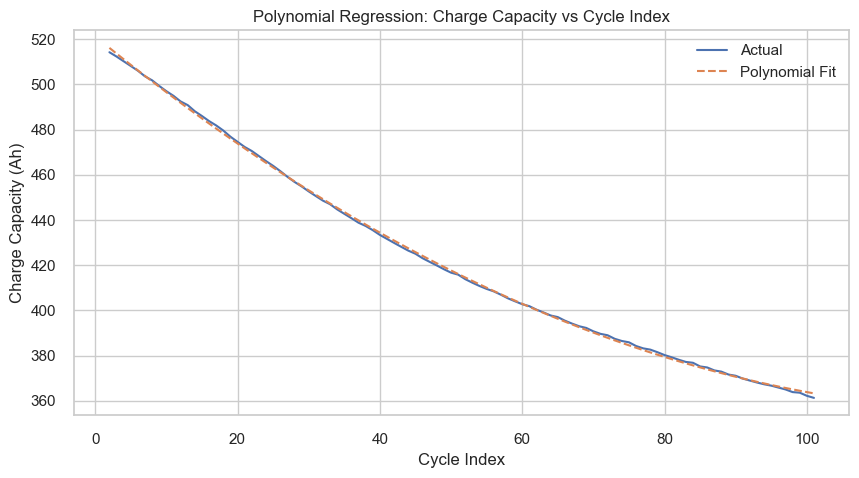

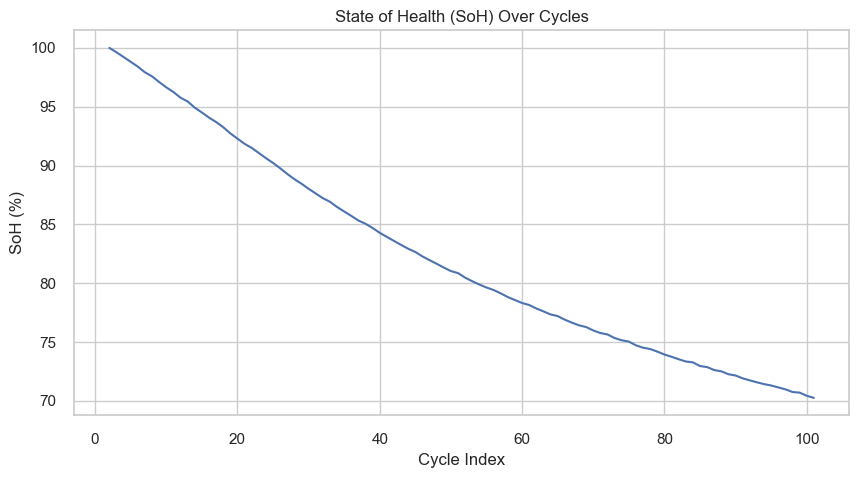

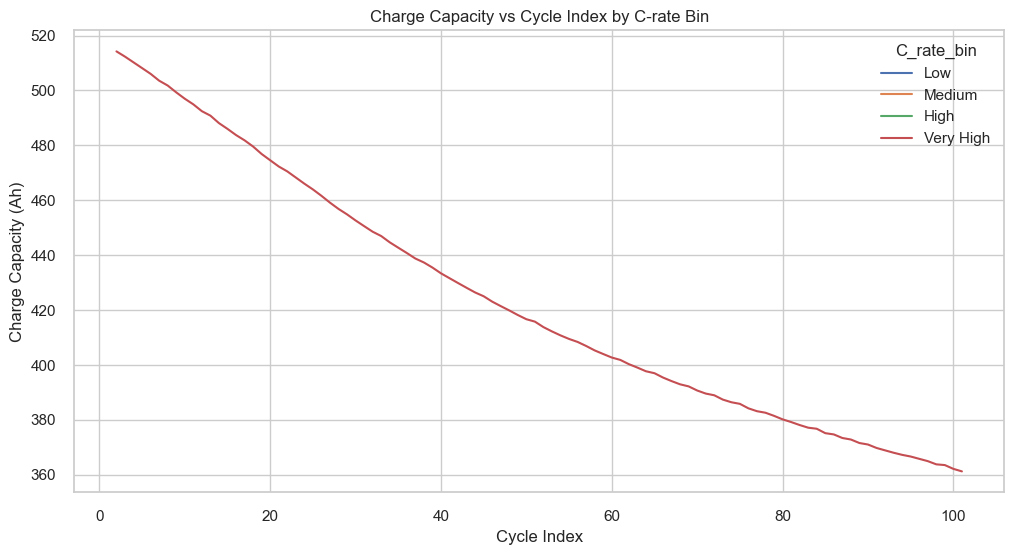

In [13]:
# Battery Data Analysis and Degradation Modelling - Complete Code

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# Load the Excel files
df1 = pd.read_excel("LR1865SZ_cycles201214_002_4.xlsx")
df2 = pd.read_excel("LR1865SZ_cycles201217_001_2.xlsx")

# Combine both datasets
df = pd.concat([df1, df2], ignore_index=True)

# Convert Test_Time(s) to numeric if needed
if not np.issubdtype(df["Test_Time(s)"].dtype, np.number):
    df["Date_Time"] = pd.to_datetime(df["Date_Time"], errors='coerce')
    df["Test_Time(s)"] = (df["Date_Time"] - df["Date_Time"].min()).dt.total_seconds()

# Drop rows with missing or invalid data
df = df.dropna(subset=["Test_Time(s)", "Current(A)", "Voltage(V)", "Capacity(Ah)", "Energy(Wh)", "Cycle_Index"])
df = df.drop_duplicates()

# Add C-rate
cell_capacity = 2.3
df["C_rate"] = df["Current(A)"].abs() / cell_capacity

# Extract charge and discharge data
charge_df = df[df["Current(A)"] > 0].copy()
discharge_df = df[df["Current(A)"] < 0].copy()

# Compute capacity incrementally per cycle
def compute_capacity(group):
    group = group.sort_values("Test_Time(s)")
    delta_t = group["Test_Time(s)"].diff().fillna(0)
    return (group["Current(A)"] * delta_t / 3600).cumsum()

charge_df["Charge_Capacity(Ah)"] = charge_df.groupby("Cycle_Index", group_keys=False).apply(compute_capacity)
discharge_df["Discharge_Capacity(Ah)"] = discharge_df.groupby("Cycle_Index", group_keys=False).apply(compute_capacity)

# Group capacities per cycle for plotting
charge_cycle_capacity = charge_df.groupby("Cycle_Index")["Charge_Capacity(Ah)"].max()
discharge_cycle_capacity = discharge_df.groupby("Cycle_Index")["Discharge_Capacity(Ah)"].min()

# Calculate SoH
initial_capacity = charge_cycle_capacity.iloc[0]
SoH = (charge_cycle_capacity / initial_capacity) * 100

# Polynomial Regression on charge capacity vs cycle index
X = charge_cycle_capacity.index.values.reshape(-1, 1)
y = charge_cycle_capacity.values
model = make_pipeline(PolynomialFeatures(2), LinearRegression())
model.fit(X, y)
y_pred = model.predict(X)

# Add C_rate_bin to charge_df for group-wise modeling
charge_df["C_rate_bin"] = pd.cut(charge_df["C_rate"], bins=[0, 0.5, 1.0, 2.0, np.inf],
                                 labels=['Low', 'Medium', 'High', 'Very High'])

# Group by C-rate bin and Cycle_Index for visualizing capacity degradation by bin
grouped_capacity_by_crate = charge_df.groupby(["Cycle_Index", "C_rate_bin"])["Charge_Capacity(Ah)"].max().unstack()

# Plots and Outputs
sns.set(style="whitegrid")

# Univariate Analysis
plt.figure(figsize=(10, 5))
sns.histplot(df["Voltage(V)"], kde=True)
plt.title("Voltage Distribution")
plt.show()

plt.figure(figsize=(10, 5))
sns.histplot(df["Current(A)"], kde=True)
plt.title("Current Distribution")
plt.show()

# Bivariate Plots
plt.figure(figsize=(10, 5))
sns.scatterplot(x="Capacity(Ah)", y="Voltage(V)", data=df)
plt.title("Capacity vs Voltage")
plt.show()

plt.figure(figsize=(10, 5))
sns.scatterplot(x="Cycle_Index", y="Energy(Wh)", data=df)
plt.title("Energy vs Cycle Index")
plt.show()

# Charge Capacity vs Voltage
plt.figure(figsize=(10, 5))
sns.lineplot(data=charge_df, x="Charge_Capacity(Ah)", y="Voltage(V)")
plt.title("Charge Capacity vs Voltage")
plt.show()

# Charge Capacity vs Cycle Index
plt.figure(figsize=(10, 5))
plt.plot(charge_cycle_capacity.index, charge_cycle_capacity.values)
plt.title("Charge Capacity vs Cycle Index")
plt.xlabel("Cycle Index")
plt.ylabel("Charge Capacity (Ah)")
plt.grid(True)
plt.show()

# Discharge Capacity vs Cycle Index
plt.figure(figsize=(10, 5))
plt.plot(discharge_cycle_capacity.index, discharge_cycle_capacity.values)
plt.title("Discharge Capacity vs Cycle Index")
plt.xlabel("Cycle Index")
plt.ylabel("Discharge Capacity (Ah)")
plt.grid(True)
plt.show()

# C-rate vs Capacity
plt.figure(figsize=(10, 5))
sns.scatterplot(x="C_rate", y="Capacity(Ah)", hue="Cycle_Index", data=charge_df, palette="viridis")
plt.title("C-rate vs Charge Capacity")
plt.show()

# Polynomial Fit vs Actual
plt.figure(figsize=(10, 5))
plt.plot(X, y, label="Actual")
plt.plot(X, y_pred, label="Polynomial Fit", linestyle='--')
plt.title("Polynomial Regression: Charge Capacity vs Cycle Index")
plt.xlabel("Cycle Index")
plt.ylabel("Charge Capacity (Ah)")
plt.legend()
plt.grid(True)
plt.show()

# State of Health
plt.figure(figsize=(10, 5))
plt.plot(charge_cycle_capacity.index, SoH)
plt.title("State of Health (SoH) Over Cycles")
plt.xlabel("Cycle Index")
plt.ylabel("SoH (%)")
plt.grid(True)
plt.show()

# Degradation by C-rate bins
grouped_capacity_by_crate.plot(figsize=(12, 6))
plt.title("Charge Capacity vs Cycle Index by C-rate Bin")
plt.xlabel("Cycle Index")
plt.ylabel("Charge Capacity (Ah)")
plt.grid(True)
plt.show()
